# Code adapted from
- https://huggingface.co/learn/nlp-course/en/chapter6/5
- http://d2l.ai/chapter_natural-language-processing-pretraining/bert.html
- https://github.com/rasbt/LLMs-from-scratch
- https://github.com/karpathy/nanoGPT/blob/master/model.py

In this notebook, we look into
- Input processing for BERT + GPT-2, including BPE
- From scratch implementations of BERT, GPT-2, Llama 2, 3, 3.1, 3.2 models (with some training and sampling)

## Input Processing

### BPE

In [4]:
from transformers import AutoTokenizer
from collections import Counter
from functools import reduce

In [5]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

In [6]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(corpus[-1]) 

[('Hopefully', (0, 9)),
 (',', (9, 10)),
 ('Ġyou', (10, 14)),
 ('Ġwill', (14, 19)),
 ('Ġbe', (19, 22)),
 ('Ġable', (22, 27)),
 ('Ġto', (27, 30)),
 ('Ġunderstand', (30, 41)),
 ('Ġhow', (41, 45)),
 ('Ġthey', (45, 50)),
 ('Ġare', (50, 54)),
 ('Ġtrained', (54, 62)),
 ('Ġand', (62, 66)),
 ('Ġgenerate', (66, 75)),
 ('Ġtokens', (75, 82)),
 ('.', (82, 83))]

In [7]:
word_freqs = Counter()
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    word_freqs += Counter([x[0] for x in words_with_offsets])
print(word_freqs)

Counter({'.': 4, 'This': 3, 'Ġis': 2, 'Ġthe': 1, 'ĠHugging': 1, 'ĠFace': 1, 'ĠCourse': 1, 'Ġchapter': 1, 'Ġabout': 1, 'Ġtokenization': 1, 'Ġsection': 1, 'Ġshows': 1, 'Ġseveral': 1, 'Ġtokenizer': 1, 'Ġalgorithms': 1, 'Hopefully': 1, ',': 1, 'Ġyou': 1, 'Ġwill': 1, 'Ġbe': 1, 'Ġable': 1, 'Ġto': 1, 'Ġunderstand': 1, 'Ġhow': 1, 'Ġthey': 1, 'Ġare': 1, 'Ġtrained': 1, 'Ġand': 1, 'Ġgenerate': 1, 'Ġtokens': 1})


In [8]:
alphabet = sorted(reduce(lambda a, b : a.union(b), [set(x) for x in word_freqs.keys()]))
print(alphabet)
vocab = ["<|endoftext|>"] + alphabet.copy()

[',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ']


In [9]:
splits = {word: [c for c in word] for word in word_freqs.keys()}
list(splits.items())[:3]

[('This', ['T', 'h', 'i', 's']),
 ('Ġis', ['Ġ', 'i', 's']),
 ('Ġthe', ['Ġ', 't', 'h', 'e'])]

In [18]:
def compute_pair_freqs(splits):
    pair_freqs = Counter()
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break

('T', 'h'): 3
('h', 'i'): 3
('i', 's'): 5
('Ġ', 'i'): 2
('Ġ', 't'): 7
('t', 'h'): 3


In [20]:
best_pair = sorted(pair_freqs, key = lambda x : pair_freqs[x], reverse = True)[0]
print(best_pair, pair_freqs[best_pair])
merges = {("Ġ", "t"): "Ġt"}
vocab.append("Ġt")

('Ġ', 't') 7


In [22]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

splits = merge_pair("Ġ", "t", splits)
print(splits["Ġtrained"])

['Ġt', 'r', 'a', 'i', 'n', 'e', 'd']


In [24]:
vocab_size = 50

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = sorted(pair_freqs, key = lambda x : pair_freqs[x], reverse = True)[0]
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

token_to_id = dict(zip(vocab, range(len(vocab))))

In [26]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split
    splits = reduce(lambda a, b : a+b, splits)
    print(splits)
    return [token_to_id[x] for x in splits]

In [28]:
def decode(token_ids):
    id_to_token = dict(zip(token_to_id.values(), token_to_id.keys()))
    return "".join([id_to_token[x] for x in token_ids]).replace("Ġ", " ")

In [30]:
token_ids = tokenize("This is not a token.")
token_ids

['This', 'Ġis', 'Ġ', 'n', 'o', 't', 'Ġa', 'Ġtoken', '.']


[38, 44, 30, 19, 20, 24, 34, 42, 2]

In [32]:
decode(token_ids)

'This is not a token.'

### From Text to Input Embeddings

In [11]:
import torch
import tiktoken
import os
import urllib.request
input_file = "../data/the-verdict.txt"

if not os.path.exists(input_file):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = input_file
    urllib.request.urlretrieve(url, file_path)

In [1]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, context_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        # Use a sliding window to chunk the book into overlapping sequences of context_length
        for i in range(0, len(token_ids) - context_length, stride):
            input_chunk = token_ids[i:i + context_length]
            target_chunk = token_ids[i + 1: i + context_length + 1] # Shift target by 1
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [2]:
def create_dataloader_v1(txt, batch_size=4, context_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, context_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    return dataloader

In [17]:
with open(input_file, "r", encoding="utf-8") as f:
    raw_text = f.read()
context_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, context_length=context_length,
    stride=context_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


In [19]:
vocab_size = tiktoken.get_encoding("gpt2").n_vocab
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
token_embeddings = token_embedding_layer(inputs)
print("Input Shape:", token_embeddings.shape, '\n') # batch_size x context_length x output_dim

pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print("Positional Embedding Shape:", pos_embeddings.shape, '\n')

input_embeddings = token_embeddings + pos_embeddings
print("Input + Positional Embedding Shape:", input_embeddings.shape) # Broadcasting

Input Shape: torch.Size([8, 4, 256]) 

Positional Embedding Shape: torch.Size([4, 256]) 

Input + Positional Embedding Shape: torch.Size([8, 4, 256])


## BERT

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

In [7]:
nn.Parameter(torch.randn(1, 5,4))

Parameter containing:
tensor([[[ 1.5738, -0.9070, -0.8343, -0.0515],
         [-0.9063,  1.3813, -0.1734, -0.5101],
         [-0.2838, -0.6132, -1.6051, -1.1009],
         [ 1.0590,  0.5096,  0.7580,  0.4336],
         [-0.7619,  0.3362, -0.1701,  1.7476]]], requires_grad=True)

In [4]:
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, max_len=1000, **kwargs):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", d2l.TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, True))
        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # Shape of `X` remains unchanged in the following code snippet:
        # (batch size, max sequence length, `num_hiddens`)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [5]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blks, dropout = 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                      num_blks, dropout)

/opt/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [8]:
tokens = torch.randint(0, vocab_size, (2, 8)) # 2 sequences with 8 tokens each
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None) 
encoded_X.shape # hidden/embedding dimension is 768

torch.Size([2, 8, 768])

In [6]:
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.LazyLinear(vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [7]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [8]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

In [9]:
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

In [10]:
# PyTorch by default will not flatten the tensor as seen in mxnet where, if
# flatten=True, all but the first axis of input data are collapsed together
encoded_X = torch.flatten(encoded_X, start_dim=1)
# input_shape for NSP: (batch size, `num_hiddens`)
nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [11]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

In [12]:
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
                                   num_heads, num_blks, dropout,
                                   max_len=max_len)
        self.fc = nn.Sequential(nn.LazyLinear(num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # encoded_X is of shape (batch_size, seq_len, num_hiddens)
        nsp_input = self.fc(encoded_X[:, 0, :])
        nsp_Y_hat = self.nsp(nsp_input)
        return encoded_X, mlm_Y_hat, nsp_Y_hat

In [39]:
# Loads input in the form we want it
# Processing is done in https://d2l.ai/chapter_natural-language-processing-pretraining/bert-dataset.html, this is important to understand but we skip for brevity

import os
import random
batch_size, max_len = 512, 64
data_dir = '../data/WikiText' # Download wikitext-2-v1 from https://www.kaggle.com/datasets/bestwater/wikitext-2-v1 to this directory
paragraphs = d2l._read_wiki(data_dir)
train_set = d2l._WikiTextDataset(paragraphs, max_len)
train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                    shuffle=True, num_workers=d2l.get_dataloader_workers())
vocab = train_set.vocab

In [40]:
net = d2l.BERTModel(len(vocab), num_hiddens=128,
                    ffn_num_hiddens=256, num_heads=2, num_blks=2, dropout=0.2)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss(reduction = None)

In [41]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    # mlm_weights_X here prevents us from computing loss on padded tokens
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [42]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    device = torch.device('cpu') if not devices else devices[0]
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(device)
            segments_X = segments_X.to(device)
            valid_lens_x = valid_lens_x.to(device) # This marks the padded indices, to be used in masking in self-attention
            pred_positions_X = pred_positions_X.to(device)
            mlm_weights_X = mlm_weights_X.to(device) # This 
            mlm_Y, nsp_y = mlm_Y.to(device), nsp_y.to(device)
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

In [44]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

In [61]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    device = torch.device('cpu') if not devices else devices[0]
    token_ids = torch.tensor(vocab[tokens], device=device).unsqueeze(0)
    segments = torch.tensor(segments, device=device).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=device).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [62]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([0.0901, 0.3364, 0.9336], grad_fn=<SliceBackward0>))

In [63]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([0.3325, 0.0918, 1.0524], grad_fn=<SliceBackward0>))

Notice how the first 3 values (out of 128) of "crane" is now different due to context

## GPT-2

### Model Specification

In [5]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch
import torch.nn as nn
import numpy as np

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [13]:
# Overall structure
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.dropout = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
        self.tok_emb.weight = self.out_head.weight # weight_tying, Raschka suggests that the model is easier to train without weight tying

        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/((2 * cfg["n_layers"]))**0.5)

    def _init_weights(self, module, std = 0.02):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.dropout(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [15]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [17]:
# GELU approximation 
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [19]:
# MLP in Transformer Block
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc = nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"])
        self.gelu = GELU()
        self.proj = nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])

    def forward(self, x):
        return self.proj(self.gelu(self.fc(x)))

In [21]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.dropout = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.dropout(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + shortcut  # Add the original input back

        return x

In [23]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)
        # (b, num_heads, num_tokens, head_dim)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)

        # (b, num_heads, num_tokens, num_tokens)
        attn_scores = torch.einsum('bhij,bhkj->bhik', q, k)
        attn_scores = attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )
        attn_weights = torch.softmax(attn_scores / k.shape[-1]**-0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        # (b, num_heads, num_tokens, head_dim)
        context_vec = torch.einsum('bhij,bhjk->bhik', attn_weights, v)

        # (b, num_tokens, num_heads, head_dim)
        context_vec = context_vec.transpose(1, 2)
        context_vec = context_vec.contiguous().view(batch_size, num_tokens, embed_dim)
        context_vec = self.proj(context_vec)
        return context_vec

In [25]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [27]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("\nOutput shape:", out.shape)
print(out[0,:3,:])


Output shape: torch.Size([2, 4, 50257])
tensor([[ 0.8853,  0.0331, -0.4912,  ...,  0.2467, -0.5241, -0.0369],
        [-0.0903,  0.3258, -0.2128,  ..., -0.0771, -0.1042, -0.0471],
        [-0.0910,  0.3692,  0.3642,  ...,  0.6514,  0.0632,  0.0331]],
       grad_fn=<SliceBackward0>)


In [31]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4
# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total number of parameters: 123,822,336
Total size of the model: 472.34 MB


In [187]:
def generate(model, idx, max_new_tokens, context_size, temperature = 1, top_k = None, eos_id = None):
    # idx has shape (batch, n_tokens) 
    # We will continually append to idx
    for _ in range(max_new_tokens):
        # Crop current context to supported context size
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        # (batch, n_tokens, vocab_size)
        logits = logits[:, -1, :]  
        if top_k is not None: # relevant when temperature is high
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)
        logits /= temperature
        probs = torch.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples = 1)  # (batch, 1)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)
    return idx

In [182]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [281]:
model.eval() # disable dropout
out = generate(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 14849, 41272, 26225, 42482, 15737, 18450]])
Output length: 10


In [283]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I amgary Meng airlines NX dealers Imagine


In [191]:
# For later sections

seed = 123
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")

### Training

In [50]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        
    "n_heads": 12,        
    "n_layers": 12,        
    "drop_rate": 0.1,      
    "qkv_bias": False      
}

In [25]:
input_file = "../data/the-verdict.txt"
with open(input_file, "r", encoding="utf-8") as f:
    text_data = f.read()

In [27]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [29]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

set_seed(seed)

# Defined above
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    context_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    context_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [31]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [33]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_set(data_loader, model, device, num_batches=None):
    '''
    num_batches : maximum number of batches to compute loss over
    '''
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the num_batches if data loader doesn't have as many
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [37]:
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
set_seed(seed)
with torch.no_grad(): 
    train_loss = calc_loss_set(train_loader, model, device)
    val_loss = calc_loss_set(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.9887482325236
Validation loss: 10.981653213500977


In [39]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_set(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_set(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context, temperature = 1):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size, temperature = temperature
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [155]:
set_seed(seed)
# Remove weight tying and weight init code, which sees to make training harder for this example
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 30
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

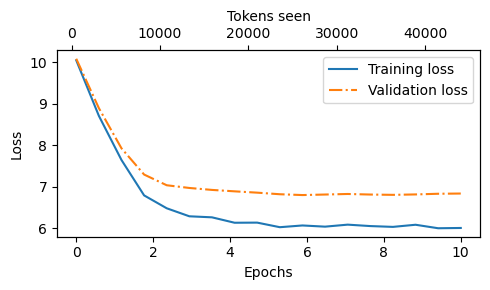

In [60]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [157]:
print("Generated Text:\n")
generate_and_print_sample(model, tokenizer, device, ' ', temperature = 0.01)
print("\nActual Text:\n")
train_text = ""
for input_batch, target_batch in train_loader:
    for batch in input_batch:
        train_text += token_ids_to_text(batch, tokenizer)
phrase = 'through the prism '
print(train_text[train_text.index(phrase) : train_text.index(phrase) + 300])

Generated Text:

  through the prism of Hermia's tears I felt able to face the fact with equanimity. Poor Jack Gisburn! The women had made him--it was fitting that they should mourn him. Among his own sex fewer regrets were heard,

Actual Text:

through the prism of Hermia's tears I felt able to face the fact with equanimity. Poor Jack Gisburn! The women had made him--it was fitting that they should mourn him. Among his own sex fewer regrets were heard, and in his own trade hardly a murmur. Professional jealousy? Perhaps. If it were, the ho


We see that the model just learnt to memorize the training sample!

### PreTrained

In [34]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split("/")[-1]
urllib.request.urlretrieve(url, f'./raschka_files/{filename}')
from raschka_files.gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [190]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [42]:
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [165]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [44]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        gpt.trf_blocks[b].att.qkv.weight = assign(
            gpt.trf_blocks[b].att.qkv.weight, 
            (params["blocks"][b]["attn"]["c_attn"])["w"].T)
        gpt.trf_blocks[b].att.qkv.bias = assign(
            gpt.trf_blocks[b].att.qkv.bias, 
            ((params["blocks"][b]["attn"]["c_attn"])["b"]))
        gpt.trf_blocks[b].att.proj.weight = assign(
            gpt.trf_blocks[b].att.proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.proj.bias = assign(
            gpt.trf_blocks[b].att.proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.fc.weight = assign(
            gpt.trf_blocks[b].ff.fc.weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.fc.bias = assign(
            gpt.trf_blocks[b].ff.fc.bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.proj.weight = assign(
            gpt.trf_blocks[b].ff.proj.weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.proj.bias = assign(
            gpt.trf_blocks[b].ff.proj.bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
load_weights_into_gpt(gpt, params)
device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
gpt.to(device);

In [56]:
set_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you must pay attention to its right money, in the first is the winner" to be exerted. All For Sure On My.


## GPT-2 to Llama 2

In [59]:
import torch
import torch.nn as nn

# To replace Layer Norm
class RMSNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.emb_dim = emb_dim
        self.weight = nn.Parameter(torch.ones(emb_dim)).float()

    def forward(self, x):
        means = x.pow(2).mean(dim=-1, keepdim=True)
        x_normed = x * torch.rsqrt(means + self.eps)
        return (x_normed * self.weight).to(dtype=x.dtype)

# To replace GELU
class SiLU(nn.Module):
    def __init__(self):
        super(SiLU, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

# In attention block
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc2 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.proj = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False)
        self.silu = SiLU()

    def forward(self, x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = self.silu(x_fc1) * x_fc2
        return self.proj(x)

See [RoPE notes](../08_attention_transformers/notes.md) for details if next cell is confusing.

In [62]:
def precompute_rope_params(head_dim, theta_base=10_000, context_length=4096, freq_config=None):
    assert head_dim % 2 == 0, "Embedding dimension must be even"
    thetas = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2).float() / head_dim))
    ms = torch.arange(context_length)
    # Shape: (context_length, head_dim // 2)
    angles = ms[:, None] * thetas[None, :]  
    # Expand angles to match the head_dim, Shape: (context_length, head_dim)
    angles = torch.cat([angles, angles], dim=1)
    cos = torch.cos(angles)
    sin = torch.sin(angles)
    return cos, sin # matrices

def compute_rope(x, cos, sin):
    # x: (batch_size, num_heads, num_tokens, head_dim)
    batch_size, num_heads, num_tokens, head_dim = x.shape
    assert head_dim % 2 == 0, "Head dimension must be even"

    # Adjust sin and cos shapes
    cos = cos[:num_tokens, :].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, num_tokens, head_dim)
    sin = sin[:num_tokens, :].unsqueeze(0).unsqueeze(0)

    # Reorder matrix columns
    x1 = x[..., : head_dim // 2]  # First half
    x2 = x[..., head_dim // 2 :]  # Second half
    rotated = torch.cat((-x2, x1), dim=-1)
    x_rotated = (x * cos) + (rotated * sin)

    return x_rotated.to(dtype=x.dtype)

In [64]:
# Reuse the mask, cos, and sin tensors in the transformer blocks to improve efficiency
class SharedBuffers:
    _buffers = {}

    @staticmethod
    def get_buffers(context_length, head_dim, dtype=torch.float32, rope_base = 10_000, freq_config = None):
        key = (context_length, head_dim, dtype, rope_base, tuple(freq_config.values()) if freq_config else freq_config)

        if key not in SharedBuffers._buffers:
            mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
            cos, sin = precompute_rope_params(head_dim, rope_base, context_length, freq_config)
            if dtype is not None:
                cos = cos.to(dtype)
                sin = sin.to(dtype)
            SharedBuffers._buffers[key] = (mask, cos, sin)

        return SharedBuffers._buffers[key]

In [66]:
# Compared to GPTBlock, we 
# - Remove bias
# - Add dtype
# - Add RoPE
# - Remove dropout
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dtype=None):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.qkv = nn.Linear(d_in, 3 * d_out, bias = False, dtype=dtype)
        self.proj = nn.Linear(d_out, d_out, bias = False, dtype=dtype)

        mask, cos, sin = SharedBuffers.get_buffers(context_length, self.head_dim, dtype)
        self.register_buffer("mask", mask)
        self.register_buffer("cos", cos)
        self.register_buffer("sin", sin)
        
    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)
        # (b, num_heads, num_tokens, head_dim)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)
        # RoPE
        k = compute_rope(k, self.cos, self.sin)
        q = compute_rope(q, self.cos, self.sin)
        
        # (b, num_heads, num_tokens, num_tokens)
        attn_scores = torch.einsum('bhij,bhkj->bhik', q, k)
        attn_scores = attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )
        attn_weights = torch.softmax(attn_scores / k.shape[-1]**-0.5, dim=-1)
        # (b, num_heads, num_tokens, head_dim)
        context_vec = torch.einsum('bhij,bhjk->bhik', attn_weights, v)

        # (b, num_tokens, num_heads, head_dim)
        context_vec = context_vec.transpose(1, 2)
        context_vec = context_vec.contiguous().view(batch_size, num_tokens, embed_dim)
        context_vec = self.proj(context_vec)
        return context_vec

In [68]:
# Compared to GPTBlock, we 
# - Remove dropout
# - Remove bias
# - Use RMSNorm
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dtype=cfg["dtype"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = RMSNorm(cfg["emb_dim"])
        self.norm2 = RMSNorm(cfg["emb_dim"])
        
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = x + shortcut  

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = x + shortcut  

        return x

In [70]:
# Compared to GPTBlock, we 
# - Remove dropout
# - Remove bias
# - Use RMSNorm
# - Remove mentions of positional embedding (MHA creates these automatically)
class Llama2Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = RMSNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])

    def forward(self, in_idx):
        tok_embeds = self.tok_emb(in_idx)
        x = tok_embeds  
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [87]:
# Compared to 1.5B parameter GPT Model
# Note the multiples of 32/64!
# We no longer specify dropout rate and qkv bias because these are removed
LLAMA2_CONFIG_7B = {
    "vocab_size": 32000,     # From 50257
    "context_length": 4096,  # From 1024
    "emb_dim": 4096,         # From 1600
    "n_heads": 32,           # From 25
    "n_layers": 32,          # From 48
    "hidden_dim": 11008,     # NEW: Size of the intermediate dimension in FeedForward, used to be 4 x emb_dim
    "dtype": torch.bfloat16  # NEW: Lower-precision dtype to reduce memory usage
}

In [89]:
model = Llama2Model(LLAMA2_CONFIG_7B)

In [90]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 6,738,415,616


In [91]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to gigabytes
    total_memory_gb = total_memory_bytes / (1024**3)

    return total_memory_gb

# Uncommenting because local machine doesn't have much memory left but this should show almost 2x as much
# print(f"float32 (PyTorch default): {model_memory_size(model, input_dtype=torch.float32):.2f} GB") 
print(f"bfloat16: {model_memory_size(model, input_dtype=torch.bfloat16):.2f} GB")

bfloat16: 25.14 GB


In [1]:
# Tokenizer difference

## Llama 2 to Llama 3.2

### Model Specification

In [91]:
LLAMA2_CONFIG_7B = {
    "vocab_size": 32_000,    
    "context_length": 4096,  
    "emb_dim": 4096,         
    "n_heads": 32,           
    "n_layers": 32,          
    "hidden_dim": 11_008,    
    "dtype": torch.bfloat16  
}
LLAMA3_CONFIG_8B = {
    "vocab_size": 128_256,   # NEW
    "context_length": 8192,  # NEW
    "emb_dim": 4096,         
    "n_heads": 32,           
    "n_layers": 32,          
    "hidden_dim": 14_336,    # NEW
    "n_kv_groups": 8,        # NEW: grouped-query attention
    "rope_base": 500_000.0,  # NEW
    "rope_freq": None,       
    "dtype": torch.bfloat16,
    "weight_tying": False
}
LLAMA31_CONFIG_8B = LLAMA3_CONFIG_8B.copy()
LLAMA31_CONFIG_8B.update({
    "context_length": 131_072, 
    "rope_freq": {              
        "factor": 8.0,
        "low_freq_factor": 1.0,
        "high_freq_factor": 4.0,
        "original_context_length": 8192,
    }
})
LLAMA32_CONFIG_1B = LLAMA31_CONFIG_8B.copy()
LLAMA32_CONFIG_1B.update({
    "emb_dim": 2048,            # Half
    "n_layers": 16,             # Half
    "hidden_dim": 8192,         # Almost half
    "rope_freq": {               
        "factor": 32.0,         # Adjustment of the rescaling factor
        "low_freq_factor": 1.0,
        "high_freq_factor": 4.0,
        "original_context_length": 8192,
    },
    "weight_tying": True        # New
})

In [74]:
# Scale down low frequencies if context window is extrapolated
def precompute_rope_params(head_dim, theta_base=10_000, context_length=4096, freq_config=None):
    assert head_dim % 2 == 0, "Embedding dimension must be even"
    #thetas
    freqs = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2).float() / head_dim))
    if freq_config is not None:
        low_freq_wavelen = freq_config["original_context_length"] / freq_config["low_freq_factor"]
        high_freq_wavelen = freq_config["original_context_length"] / freq_config["high_freq_factor"]
        wavelens = 2 * torch.pi / freqs
        # When wavelengths > context_length, decrease frequency
        freqs_llama = torch.where(
            wavelens > low_freq_wavelen, freqs / freq_config["factor"], freqs
        )
        smooth_factor = (freq_config["original_context_length"] / wavelens - freq_config["low_freq_factor"]) / (
            freq_config["high_freq_factor"] - freq_config["low_freq_factor"]
        )
        smoothed_freqs = (
            (1 - smooth_factor) * (freqs / freq_config["factor"]) + smooth_factor * freqs
        )
        is_medium_freq = (wavelens <= low_freq_wavelen) & (wavelens >= high_freq_wavelen)
        # When 1/4*context_length < wavelengths < context_length, decrease frequency by a smoothed amount
        freqs_llama = torch.where(is_medium_freq, smoothed_freqs, freqs_llama)
        freqs = freqs_llama
    ms = torch.arange(context_length)
    # Shape: (context_length, head_dim // 2)
    angles = ms[:, None] * freqs[None, :]  
    # Expand angles to match the head_dim, Shape: (context_length, head_dim)
    angles = torch.cat([angles, angles], dim=1)
    cos = torch.cos(angles)
    sin = torch.sin(angles)
    return cos, sin # matrices

In [76]:
# This is oldf
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, num_heads, context_length, dtype=None):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.qkv = nn.Linear(d_in, 3 * d_out, bias = False, dtype=dtype)
        self.proj = nn.Linear(d_out, d_out, bias = False, dtype=dtype)

        mask, cos, sin = SharedBuffers.get_buffers(context_length, self.head_dim, dtype)
        self.register_buffer("mask", mask)
        self.register_buffer("cos", cos)
        self.register_buffer("sin", sin)
        
    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)
        # (b, num_heads, num_tokens, head_dim)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)
        # RoPE
        k = compute_rope(k, self.cos, self.sin)
        q = compute_rope(q, self.cos, self.sin)
        
        # (b, num_heads, num_tokens, num_tokens)
        attn_scores = torch.einsum('bhij,bhkj->bhik', q, k)
        attn_scores = attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )
        attn_weights = torch.softmax(attn_scores / k.shape[-1]**-0.5, dim=-1)
        # (b, num_heads, num_tokens, head_dim)
        context_vec = torch.einsum('bhij,bhjk->bhik', attn_weights, v)

        # (b, num_tokens, num_heads, head_dim)
        context_vec = context_vec.transpose(1, 2)
        context_vec = context_vec.contiguous().view(batch_size, num_tokens, embed_dim)
        context_vec = self.proj(context_vec)
        return context_vec

In [212]:
# This reduces the number of parameters by around a third
class GroupedQueryAttention(nn.Module):
    def __init__(
            self, d_in, d_out, context_length, num_heads,
            num_kv_groups,       # NEW
            rope_base=10_000,    # NEW
            rope_config=None,    # NEW
            dtype=None
        ):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"  # NEW

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.num_kv_groups = num_kv_groups
        self.q_to_k_ratio = num_heads // num_kv_groups
        self.qkv = nn.Linear(d_in, d_out + 2 * num_kv_groups * self.head_dim, bias = False, dtype=dtype)
        self.out_proj = nn.Linear(d_out, d_out, bias=False, dtype=dtype)

        mask, cos, sin = SharedBuffers.get_buffers(context_length, self.head_dim, dtype, rope_base, rope_config)
        self.register_buffer("mask", mask)
        self.register_buffer("cos", cos)
        self.register_buffer("sin", sin)

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, embed_dim + 2*num_kv_groups*head_dim)
        qkv = self.qkv(x)
        # (b, num_heads, num_tokens, head_dim)
        q = qkv[:,:,:embed_dim].view(batch_size, num_tokens, self.num_heads, self.head_dim).transpose(1,2)
        # (b, num_kv_groups, num_tokens, head_dim)
        k, v = qkv[:,:,embed_dim:].view(batch_size, num_tokens, 2, self.num_kv_groups, self.head_dim).permute(2, 0, 3, 1, 4)
        # RoPE
        k = compute_rope(k, self.cos, self.sin)
        q = compute_rope(q, self.cos, self.sin)
        # Expand keys and values to match the number of heads, Shape: (b, num_heads, num_tokens, head_dim)
        # Repeat_interleave does [K1, K1, K2, K2], while repeat does [K1, K2, K1, K2]
        k = k.repeat_interleave(self.q_to_k_ratio, dim=1) 
        v = v.repeat_interleave(self.q_to_k_ratio, dim=1)  

        # (b, num_heads, num_tokens, num_tokens)
        attn_scores = torch.einsum('bhij,bhkj->bhik', q, k)
        attn_scores = attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )
        attn_weights = torch.softmax(attn_scores / k.shape[-1]**-0.5, dim=-1)
        # (b, num_heads, num_tokens, head_dim)
        context_vec = torch.einsum('bhij,bhjk->bhik', attn_weights, v)

        # (b, num_tokens, num_heads, head_dim)
        context_vec = context_vec.transpose(1, 2)
        context_vec = context_vec.contiguous().view(batch_size, num_tokens, embed_dim)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [214]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att =  GroupedQueryAttention(  
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            num_kv_groups=cfg["n_kv_groups"],  # NEW
            rope_base=cfg["rope_base"],        # NEW
            rope_config=cfg["rope_freq"],      # NEW
            dtype=cfg["dtype"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = RMSNorm(cfg["emb_dim"], eps=1e-5)
        self.norm2 = RMSNorm(cfg["emb_dim"], eps=1e-5)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x.to(torch.bfloat16)) 
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x.to(torch.bfloat16))
        x = x + shortcut  

        return x

In [216]:
class Llama3Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = RMSNorm(cfg["emb_dim"], eps=1e-5)
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])
        if cfg["weight_tying"]:
            self.tok_emb.weight = self.out_head.weight

    def forward(self, in_idx):
        tok_embeds = self.tok_emb(in_idx)
        x = tok_embeds
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x.to(torch.bfloat16))
        return logits

### Pre-Trained

In [99]:
# Rescale base wavelength to run on smaller machine
def rescale_theta(theta_old, context_length_old, context_length_new):
    scaling_factor = context_length_new / context_length_old
    theta_new = theta_old * scaling_factor
    return theta_new

# Change context length
old_context_length = LLAMA32_CONFIG_1B["context_length"]
LLAMA32_CONFIG_1B["context_length"] = 8192

LLAMA32_CONFIG_1B["rope_base"] = rescale_theta(
    LLAMA32_CONFIG_1B["rope_base"],
    old_context_length,
    LLAMA32_CONFIG_1B["context_length"]
)

print("New RoPE theta:", LLAMA32_CONFIG_1B["rope_base"])

New RoPE theta: 31250.0


In [101]:
import os
from pathlib import Path

import tiktoken
from tiktoken.load import load_tiktoken_bpe

class Tokenizer:
    def __init__(self, model_path):
        assert os.path.isfile(model_path), f"Model file {model_path} not found"
        mergeable_ranks = load_tiktoken_bpe(model_path)

        self.special_tokens = {
            "<|begin_of_text|>": 128000,
            "<|end_of_text|>": 128001,
            "<|start_header_id|>": 128006,
            "<|end_header_id|>": 128007,
            "<|eot_id|>": 128009,
        }
        self.special_tokens.update({
            f"<|reserved_{i}|>": 128002 + i for i in range(256) if (128002 + i) not in self.special_tokens.values()
        })

        self.model = tiktoken.Encoding(
            name=Path(model_path).name,
            pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
            mergeable_ranks=mergeable_ranks,
            special_tokens=self.special_tokens
        )


    def encode(self, text, bos=False, eos=False, allowed_special=set(), disallowed_special=()):
        if bos:
            tokens = [self.special_tokens["<|begin_of_text|>"]]
        else:
            tokens = []

        tokens += self.model.encode(text, allowed_special=allowed_special, disallowed_special=disallowed_special)

        if eos:
            tokens.append(self.special_tokens["<|end_of_text|>"])
        return tokens

    def decode(self, tokens):
        return self.model.decode(tokens)

In [115]:
# from huggingface_hub import login
# login(token=) # Fill this in

In [119]:
from huggingface_hub import hf_hub_download

tokenizer_file_path = hf_hub_download(
    repo_id="meta-llama/Llama-3.2-1B",
    filename="original/tokenizer.model",
    local_dir="Llama-3.2-1B"
)

tokenizer = Tokenizer(tokenizer_file_path)

In [218]:
model = Llama3Model(LLAMA32_CONFIG_1B)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 1,235,814,400


In [219]:
from safetensors.torch import load_file
# weights_file = hf_hub_download(
#     repo_id="meta-llama/Llama-3.2-1B",
#     filename=f"model.safetensors",
#     local_dir="Llama-3.2-1B"
# )
weights_file = './Llama-3.2-1B/.cache/huggingface/download/original/model.safetensors'
current_weights = load_file(weights_file)

In [135]:
for pn, p in model.named_parameters():
    if ".0." in pn:
        print(pn)

trf_blocks.0.att.qkv.weight
trf_blocks.0.att.out_proj.weight
trf_blocks.0.ff.fc1.weight
trf_blocks.0.ff.fc2.weight
trf_blocks.0.ff.proj.weight
trf_blocks.0.norm1.weight
trf_blocks.0.norm2.weight


In [177]:
def load_weights_into_llama(model, param_config, params):
    model.tok_emb.weight = assign(model.tok_emb.weight, params["model.embed_tokens.weight"])

    for l in range(param_config["n_layers"]):

        # Load attention weights
        model.trf_blocks[l].att.qkv.weight = assign(
            model.trf_blocks[l].att.qkv.weight,
            torch.cat([params[f"model.layers.{l}.self_attn.q_proj.weight"], 
                       params[f"model.layers.{l}.self_attn.k_proj.weight"], 
                       params[f"model.layers.{l}.self_attn.v_proj.weight"]], axis = 0)
        )
        model.trf_blocks[l].att.out_proj.weight = assign(
            model.trf_blocks[l].att.out_proj.weight,
            params[f"model.layers.{l}.self_attn.o_proj.weight"]
        )
        model.trf_blocks[l].norm1.weight = assign(
            model.trf_blocks[l].norm1.weight,
            params[f"model.layers.{l}.input_layernorm.weight"]
        )

        # Load FeedForward weights
        model.trf_blocks[l].ff.fc1.weight = assign(
            model.trf_blocks[l].ff.fc1.weight,
            params[f"model.layers.{l}.mlp.gate_proj.weight"]
        )
        model.trf_blocks[l].ff.fc2.weight = assign(
            model.trf_blocks[l].ff.fc2.weight,
            params[f"model.layers.{l}.mlp.up_proj.weight"]
        )
        model.trf_blocks[l].ff.proj.weight = assign(
            model.trf_blocks[l].ff.proj.weight,
            params[f"model.layers.{l}.mlp.down_proj.weight"]
        )
        model.trf_blocks[l].norm2.weight = assign(
            model.trf_blocks[l].norm2.weight,
            params[f"model.layers.{l}.post_attention_layernorm.weight"]
        )

    # Load output layer weights
    model.final_norm.weight = assign(model.final_norm.weight, params["model.norm.weight"])

In [222]:
load_weights_into_llama(model, LLAMA32_CONFIG_1B, current_weights)
del current_weights  # free up memory

/var/folders/2v/0s_wd0cd04g3xtcdpppg90980000gn/T/ipykernel_88865/1629613674.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.nn.Parameter(torch.tensor(right))


In [267]:
def generate(model, idx, max_new_tokens, context_size, temperature = 1, top_k = None, eos_id = None):
    # idx has shape (batch, n_tokens) 
    # We will continually append to idx
    for _ in range(max_new_tokens):
        # Crop current context to supported context size
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        
        # (batch, n_tokens, vocab_size)
        logits = logits[:, -1, :]  
        if top_k is not None: # relevant when temperature is high
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)
        logits /= temperature
        probs = torch.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples = 1)  # (batch, 1)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)
    return idx

In [271]:
set_seed(seed)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort", tokenizer),
    max_new_tokens=25,
    context_size=LLAMA32_CONFIG_1B["context_length"],
    top_k=1,
    temperature=1.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort is made to ensure that the information on this website is accurate. However, we cannot guarantee that the information is accurate, complete
